In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from train_config import *


os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"



2024-04-11 19:56:28.725764: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 19:56:28.749548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
captionings_df = pd.read_csv(os.path.join(DATA_PATH, "results.csv"), sep="|").dropna()
captionings_df.columns = ["image_name", "comment_number", "comment"]
captionings_df["image_name"] = IMAGES_PATH + "/" + captionings_df["image_name"] 


#ADDING START AND END special tokens
captionings_df["comment"] = "<START> " + captionings_df["comment"] + " <END>"
captionings_df.head(10)

,image_name,comment_number,comment
0,data/flickr30k_images/flickr30k_images//100009...,0,<START> Two young guys with shaggy hair look ...
1,data/flickr30k_images/flickr30k_images//100009...,1,"<START> Two young , White males are outside n..."
2,data/flickr30k_images/flickr30k_images//100009...,2,<START> Two men in green shirts are standing ...
3,data/flickr30k_images/flickr30k_images//100009...,3,<START> A man in a blue shirt standing in a g...
4,data/flickr30k_images/flickr30k_images//100009...,4,<START> Two friends enjoy time spent together...
5,data/flickr30k_images/flickr30k_images//100024...,0,<START> Several men in hard hats are operatin...
6,data/flickr30k_images/flickr30k_images//100024...,1,<START> Workers look down from up above on a ...
7,data/flickr30k_images/flickr30k_images//100024...,2,<START> Two men working on a machine wearing ...
8,data/flickr30k_images/flickr30k_images//100024...,3,<START> Four men on top of a tall structure ....
9,data/flickr30k_images/flickr30k_images//100024...,4,<START> Three men on a large rig . <END>


In [3]:
#Shuffle df
captionings_df = captionings_df.sample(frac=1,
                                       random_state=42,
                                       replace=False,
                                       )


n_train_examples = int(len(captionings_df) * (1 - VAL_FRACTION))

train_captionings_df = captionings_df[ : n_train_examples]
val_captionings_df = captionings_df[n_train_examples : ]

print("Train image-text examples: ", train_captionings_df.shape[0])
print("Validation image-text examples: ", val_captionings_df.shape[0])

#save splits
train_captionings_df.to_csv("splits/train_captions.csv", index=False)
val_captionings_df.to_csv("splits/val_captions.csv", index=False)

Train image-text examples:  150968
Validation image-text examples:  7946


In [4]:
from data_processing import build_tokenizer, build_image_augmenter,  decode_and_resize


tokenizer = build_tokenizer()
tokenizer.adapt(train_captionings_df["comment"].tolist())

def process_input(img_path, captions):
    return decode_and_resize(img_path), tf.reshape(tokenizer(captions), shape=(1, SEQ_LENGTH))

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


2024-04-11 19:56:32.539707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 19:56:32.559322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 19:56:32.559405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
train_dataset = make_dataset(train_captionings_df["image_name"].tolist(),
                             train_captionings_df["comment"].tolist())

val_dataset = make_dataset(train_captionings_df["image_name"].tolist(),
                             train_captionings_df["comment"].tolist())


In [6]:
for img, cap in val_dataset.take(5):
    print(img.shape, cap.shape)

(128, 224, 224, 3) (128, 1, 20)
(128, 224, 224, 3) (128, 1, 20)
(128, 224, 224, 3) (128, 1, 20)
(128, 224, 224, 3) (128, 1, 20)
(128, 224, 224, 3) (128, 1, 20)


In [7]:
from model import TransformerDecoderBlock, TransformerEncoderBlock, ImageCaptioningModel, get_cnn_model

In [8]:
base_model = keras.applications.efficientnet.EfficientNetB1(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )

cnn = get_cnn_model(base_model)

encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=ENC_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=DEC_HEADS, 
)

caption_model = ImageCaptioningModel(
    cnn_model=cnn,
    encoder=encoder, 
    decoder=decoder
)





In [9]:
X_batch, y_batch = next(iter(train_dataset.take(1))) #SANITY CHECK


cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="none"
)


caption_model.compile(optimizer=keras.optimizers.Adam(0.001), loss=cross_entropy)

In [10]:
caption_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10


2024-04-11 19:56:44.053484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-11 19:56:44.065074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 19:56:44.469719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6c72f5f0e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 19:56:44.469744: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-04-11 19:56:44.473044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 19:56:44.536415: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

 604/1180 [==============>...............] - ETA: 1:23 - loss: 4.0170 - acc: 0.2698

KeyboardInterrupt: 

In [11]:
#save
caption_model.save_weights("caption_weights.h5")

In [12]:


from training_utils import load_trained_model_weights



new_model = load_trained_model_weights("caption_weights.h5")

In [13]:
new_model.summary()

Model: "image_captioning_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 49, 1280)          6575239   
                                                                 
 transformer_encoder_block_  multiple                  2760192   
 1 (TransformerEncoderBlock                                      
 )                                                               
                                                                 
 transformer_decoder_block_  multiple                  14727696  
 1 (TransformerDecoderBlock                                      
 )                                                               
                                                                 
Total params: 24063131 (91.79 MB)
Trainable params: 17487888 (66.71 MB)
Non-trainable params: 6575243 (25.08 MB)
_____________________________________________________________

In [14]:
new_model.compile(optimizer=keras.optimizers.Adam(0.001), loss=cross_entropy)

new_model.evaluate(X_batch, y_batch)

4/4 [==============================] - 1s 29ms/step - loss: 3.5317 - acc: 0.3610


[3.5317282676696777, 0.35217100381851196]

In [15]:
import gc

In [16]:
gc.collect()

1858

In [31]:
vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = val_captionings_df.iloc[1: 100]["image_name"].to_list()

import matplotlib.pyplot as plt
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    print(img)
    plt.imshow(img / 255.0)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   1   0]
  [  0   1   0]
  [  0   2   0]
  ...
  [151 166 163]
  [147 164 158]
  [144 161 155]]

 [[  0   1   0]
  [  0   1   0]
  [  0   2   0]
  ...
  [151 167 164]
  [144 161 155]
  [143 160 154]]

 [[  0   1   0]
  [  0   1   0]
  [  0   2   0]
  ...
  [148 166 162]
  [147 164 158]
  [145 162 156]]]


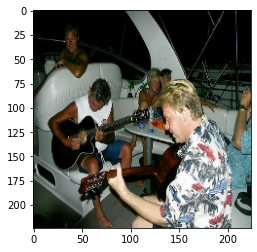

Predicted Caption:  a man in a white shirt is playing a guitar end of a game end of a man in


In [32]:
generate_caption()